In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv

import random
import pickle

import sys
import time

In [2]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor
from sklearn.ensemble       import AdaBoostRegressor

from sklearn.multioutput    import MultiOutputRegressor

from sklearn.utils          import shuffle

from sklearn.metrics        import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [3,5,8,10,15,20,25,30]  # Generate an algorithm for predicting every few days
mom_nums  = [3,5,8,10,15,20,25,30]  # Momentum has many good tracers
rsi_nums  = [10,15,20,25,30]        # Good for some long term trends
band_nums = [5,8,10,15,20,25]       # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [6]:
#scaled_df = sf.gen_pca_attributes( scaled_df, mom_nums, rsi_nums, band_nums, n_mom=3, n_rsi=2, n_ban=2 )

In [7]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [7]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df )


# Seperate features from target data
close_list = ['close']
for i in roll_nums:
    close_list.append( 'close_mean_'+str(i) )

targets  = shuff_scaled_df[close_list]
features = shuff_scaled_df.drop( close_list, axis=1 )



n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.8

# Size of training set
n_train = int( percent_train * n_elements )


# Seperate training and test data
train_features = features[ : n_train   ]
test_features  = features[   n_train : ]

train_targets  =  targets[ : n_train   ].drop( 'close', axis=1 )
test_targets   =  targets[   n_train : ].drop( 'close', axis=1 )

In [8]:
# Gets the location of not null values
train_not_null_locations = train_targets.notnull().all( axis=1 )==1
test_not_null_locations  =  test_targets.notnull().all( axis=1 )==1

# Take features and targets that are not null
train_x = train_features[ train_not_null_locations ].values
test_x  =  test_features[  test_not_null_locations ].values

train_y = train_targets[ train_not_null_locations ].values
test_y  =  test_targets[  test_not_null_locations ].values

ad_mult_reg = MultiOutputRegressor( AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=20, max_features=0.7 ), 
#                            loss='exponential', n_estimators=10 ) )
                            loss='exponential', n_estimators=5 ) )
#                            loss='exponential', n_estimators=3 ) )

ad_mult_reg.fit( train_x, train_y )

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=1.0, loss='exponential', n_estimators=5,
         random_state=None),
           n_jobs=1)

In [9]:
test_60 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_60[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.28736, Percent ME : 36.03992
 close_mean_5 MSE :  0.01817, Percent ME :  9.06243
 close_mean_7 MSE :  0.02099, Percent ME :  9.73959
close_mean_10 MSE :  0.00909, Percent ME :  6.41166
close_mean_12 MSE :  0.02232, Percent ME : 10.04452
close_mean_15 MSE :  0.02216, Percent ME : 10.00922


In [29]:
test_70 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_70[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.11175, Percent ME : 22.26275
 close_mean_5 MSE :  0.02046, Percent ME :  9.52490
 close_mean_7 MSE :  0.01597, Percent ME :  8.41539
close_mean_10 MSE :  0.00119, Percent ME :  2.29876
close_mean_12 MSE :  0.23849, Percent ME : 32.52288
close_mean_15 MSE :  0.26986, Percent ME : 34.59590


In [12]:
test_80 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00034, Percent ME :  1.28400
 close_mean_5 MSE :  0.00052, Percent ME :  1.57940
 close_mean_7 MSE :  0.00769, Percent ME :  6.09548
close_mean_10 MSE :  0.00520, Percent ME :  5.01383
close_mean_12 MSE :  0.04772, Percent ME : 15.18780
close_mean_15 MSE :  0.01710, Percent ME :  9.09208
close_mean_20 MSE :  0.04250, Percent ME : 14.33349
close_mean_25 MSE :  0.10339, Percent ME : 22.35573


In [8]:
test_80_5 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00052, Percent ME :  1.58310
 close_mean_5 MSE :  0.01097, Percent ME :  7.28296
 close_mean_7 MSE :  0.02160, Percent ME : 10.21904
close_mean_10 MSE :  0.00542, Percent ME :  5.11623
close_mean_12 MSE :  0.04154, Percent ME : 14.17041
close_mean_15 MSE :  0.01140, Percent ME :  7.42228
close_mean_20 MSE :  0.01214, Percent ME :  7.66086
close_mean_25 MSE :  0.06858, Percent ME : 18.20686


In [8]:
test_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.04622, Percent ME : 16.03829
 close_mean_5 MSE :  0.00280, Percent ME :  3.95061
 close_mean_7 MSE :  0.06953, Percent ME : 19.67037
close_mean_10 MSE :  0.03379, Percent ME : 13.71227
close_mean_12 MSE :  0.00471, Percent ME :  5.11735
close_mean_15 MSE :  0.26712, Percent ME : 38.55589
close_mean_18 MSE :  0.02227, Percent ME : 11.13333
close_mean_20 MSE :  0.00127, Percent ME :  2.66170
close_mean_23 MSE :  0.00853, Percent ME :  6.89029
close_mean_25 MSE :  0.02849, Percent ME : 12.59120
close_mean_28 MSE :  0.00738, Percent ME :  6.40677
close_mean_30 MSE :  0.02438, Percent ME : 11.64905


In [8]:
test_80_3_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.01164, Percent ME :  8.63749
 close_mean_5 MSE :  0.00212, Percent ME :  3.68463
 close_mean_7 MSE :  0.08406, Percent ME : 23.21046
close_mean_10 MSE :  0.00056, Percent ME :  1.89508
close_mean_12 MSE :  0.00012, Percent ME :  0.86886
close_mean_15 MSE :  0.00403, Percent ME :  5.08291
close_mean_18 MSE :  0.01355, Percent ME :  9.31947
close_mean_20 MSE :  0.04023, Percent ME : 16.05616
close_mean_23 MSE :  0.00035, Percent ME :  1.48873
close_mean_25 MSE :  0.00362, Percent ME :  4.81892
close_mean_28 MSE :  0.08284, Percent ME : 23.04127
close_mean_30 MSE :  0.00043, Percent ME :  1.66966


In [9]:
test_80_3_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(abs(test_y) ) )

 close_mean_3 MSE :  0.00222, Percent ME :  0.42910
 close_mean_5 MSE :  0.01836, Percent ME :  1.23313
 close_mean_8 MSE :  0.01501, Percent ME :  1.11468
close_mean_10 MSE :  0.01245, Percent ME :  1.01514
close_mean_15 MSE :  0.00850, Percent ME :  0.83905
close_mean_20 MSE :  0.01199, Percent ME :  0.99655
close_mean_25 MSE :  0.00141, Percent ME :  0.34111
close_mean_30 MSE :  0.00918, Percent ME :  0.87200


In [9]:
test_80_5_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00037, Percent ME :  2.91972
 close_mean_5 MSE :  0.00019, Percent ME :  2.10955
 close_mean_8 MSE :  0.00011, Percent ME :  1.58863
close_mean_10 MSE :  0.00070, Percent ME :  4.01147
close_mean_15 MSE :  0.00012, Percent ME :  1.64108
close_mean_20 MSE :  0.00145, Percent ME :  5.77063
close_mean_25 MSE :  0.00054, Percent ME :  3.53704
close_mean_30 MSE :  0.00101, Percent ME :  4.82535


In [10]:
pred_values = test_80_5_most

std_dict = {}

for i in range( 0, len( close_list[1:] ) ) :
    rmse = np.sqrt( mean_squared_error( test_y[i], pred_values[i] ) )
    col  = 'std_' + str( roll_nums[i] )
    std_dict[col] = rmse
    print '%13s   RMSE : %8.5f,   RMSE/mean : %8.5f' % ( close_list[i+1], rmse, rmse/np.mean( abs(test_y)) )
    
print std_dict

 close_mean_3   RMSE :  0.01926,   RMSE/mean :  0.42262
 close_mean_5   RMSE :  0.01391,   RMSE/mean :  0.30535
 close_mean_8   RMSE :  0.01048,   RMSE/mean :  0.22995
close_mean_10   RMSE :  0.02646,   RMSE/mean :  0.58065
close_mean_15   RMSE :  0.01082,   RMSE/mean :  0.23754
close_mean_20   RMSE :  0.03806,   RMSE/mean :  0.83529
close_mean_25   RMSE :  0.02333,   RMSE/mean :  0.51198
close_mean_30   RMSE :  0.03182,   RMSE/mean :  0.69846
{'std_25': 0.023328026687096451, 'std_30': 0.031824919926968669, 'std_20': 0.038059339060794291, 'std_15': 0.010823510550578914, 'std_10': 0.026457095216153591, 'std_5': 0.013913249317942538, 'std_3': 0.019256583725926684, 'std_8': 0.010477566820367989}


In [47]:
quote_name = 'aapl'


# Generate df with the actual rolling averages
close_df = rq.readQuote( 'quotes/'+ quote_name +'.csv' )
close_df = pd.merge( close_df['close'].to_frame(), sf.generate_rolling_close( close_df, roll_nums, onlyMean=True ), left_index=True, right_index=True )
close_means = close_df.columns.values


# Generate predicted rolling mean percentage increases
pred_df     = sf.get_scaled_data( [quote_name], roll_nums, mom_nums, rsi_nums, band_nums ).dropna()
pred_values = ad_mult_reg.predict( pred_df.drop( close_means, axis=1 ) )


# Adjust close to match pred df shape
close_df = close_df.ix[ pred_df.index.values ].dropna()

# Pred percent increase = future/now - 1
for i in range( 0 , pred_values.shape[1] ):
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( pred_values[:,i] + 1 ) * close_df[ 'close_mean_' + str( roll_nums[i] ) ]
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift( -roll_nums[i]+1 )
#    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( close_df[ 'pred_mean_' + str( roll_nums[i] ) ] + 
#                                                       close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift(-1) ) / 2.
close_df = close_df.dropna()

In [167]:
close_df.head()

,close,close_mean_3,close_mean_5,close_mean_8,close_mean_10,close_mean_15,close_mean_20,close_mean_25,close_mean_30,pred_mean_3,pred_mean_5,pred_mean_8,pred_mean_10,pred_mean_15,pred_mean_20,pred_mean_25,pred_mean_30
date,,,,,,,,,,,,,,,,,
2017/01/26,121.94,121.263333,120.774,120.45500,120.193,119.620000,118.789,118.3944,117.955667,208.791251,119.759309,118.505275,119.604852,115.494349,116.344587,117.181735,113.388414
2017/01/25,121.88,120.643333,120.342,120.09250,119.974,119.225333,118.555,118.1824,117.667667,236.245014,120.412410,118.470022,119.181347,116.707650,116.821149,116.636443,117.453010
2017/01/24,119.97,120.016667,119.964,119.76375,119.697,118.843333,118.287,117.9460,117.403333,231.173479,119.924407,119.180478,119.262705,117.204639,116.916158,116.572444,116.714718
2017/01/23,120.08,119.953333,119.970,119.73625,119.599,118.566667,118.103,117.7800,117.141667,232.132626,119.452020,118.663568,117.415120,115.906103,116.913415,116.136060,115.940933
2017/01/20,120.00,119.923333,119.762,119.61500,119.382,118.343333,117.952,117.5844,116.840000,197.932590,119.194597,119.071250,117.238647,115.512525,116.929475,115.835363,115.553034


In [175]:
close_df.shift(-3+1).tail(32)

,close,close_mean_3,close_mean_5,close_mean_8,close_mean_10,close_mean_15,close_mean_20,close_mean_25,close_mean_30,pred_mean_3,pred_mean_5,pred_mean_8,pred_mean_10,pred_mean_15,pred_mean_20,pred_mean_25,pred_mean_30
date,,,,,,,,,,,,,,,,,
2007/06/06,17.3329,17.186733,16.97260,16.629300,16.52515,16.194673,15.945580,15.618576,15.305280,7.313653,17.280049,17.217631,17.184134,17.008809,17.111565,17.044405,17.106167
2007/06/05,16.9143,17.064800,16.75230,16.490187,16.36357,16.074767,15.799005,15.496232,15.160707,6.604485,17.028247,17.038566,17.060322,17.070073,17.044171,16.808236,16.853277
2007/06/04,17.3130,16.871933,16.53202,16.375537,16.23557,15.969433,15.670435,15.384460,15.026753,19.054520,16.945708,17.106014,17.270129,16.990611,16.631713,17.041531,16.840483
2007/06/01,16.9671,16.511400,16.29484,16.176050,16.03770,15.833140,15.521855,15.236784,14.880130,8.509818,16.813806,17.136891,16.878756,17.041740,16.457089,17.001683,16.738274
2007/05/31,16.3357,16.126667,16.14542,16.009450,15.87699,15.702573,15.384000,15.090900,14.744797,6.096619,16.728986,17.011085,16.753680,16.979725,16.118090,17.012485,16.652480
2007/05/30,16.2314,16.057133,16.07770,15.884275,15.80571,15.603240,15.280070,14.971816,14.635653,16.691807,16.253046,16.200324,16.018295,16.379199,16.167284,16.025104,16.075893
2007/05/29,15.8129,16.053333,15.97484,15.775350,15.73600,15.481240,15.182215,14.842388,14.524320,19.010875,15.699293,15.500338,15.922791,15.675257,15.550460,15.644671,15.554559
2007/05/25,16.1271,16.114733,15.93912,15.751600,15.68814,15.383240,15.097570,14.725700,14.436223,21.316136,15.967020,16.219141,16.492874,16.350110,16.359873,16.225838,16.469163
2007/05/24,16.2200,15.978067,15.78056,15.677500,15.60229,15.264193,14.972270,14.597188,14.339557,8.661472,15.886243,16.172561,16.382977,15.972631,16.604922,16.432503,16.766069


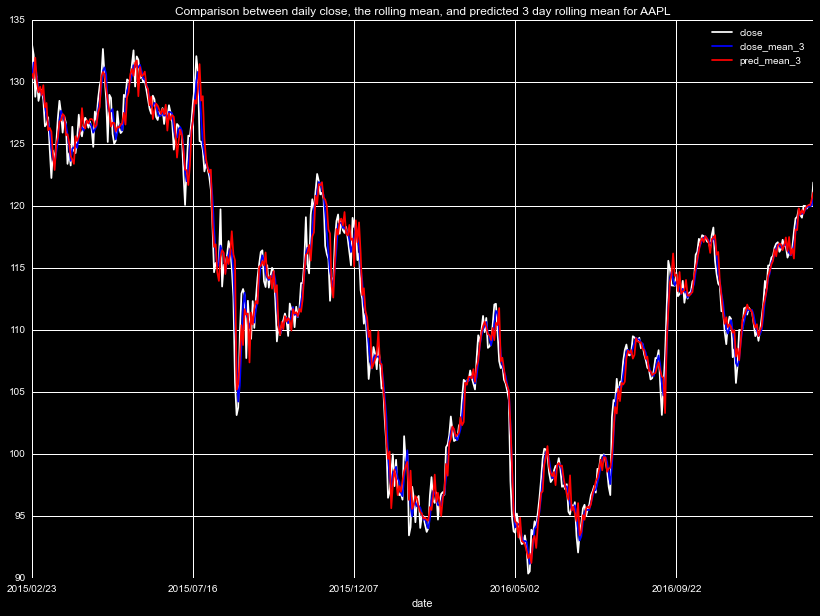

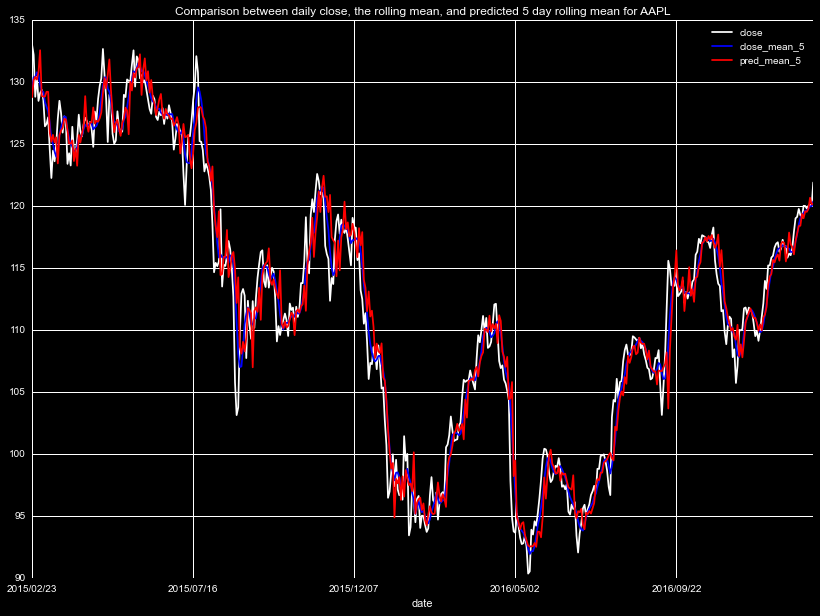

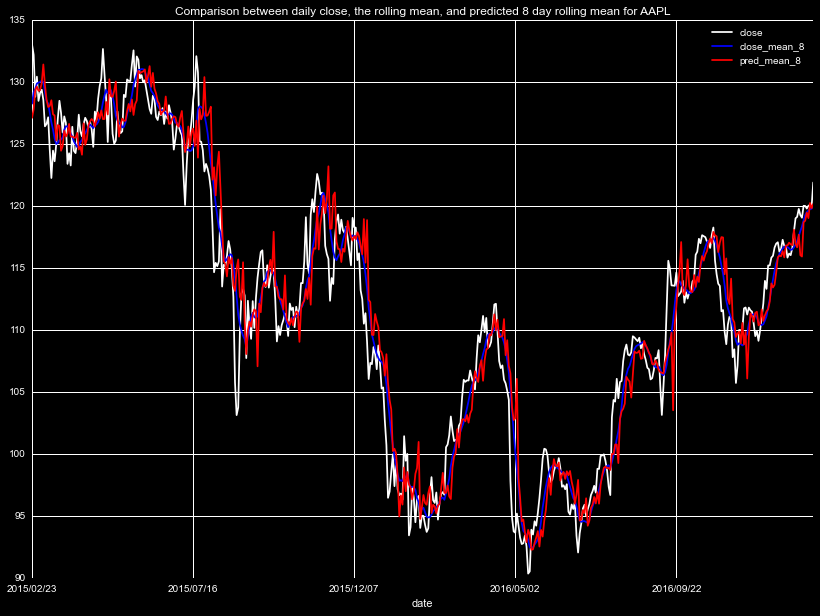

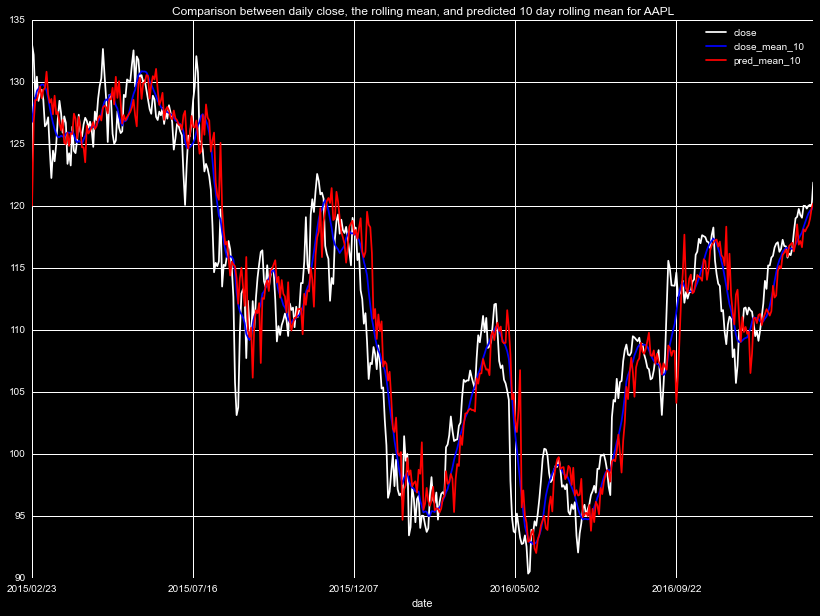

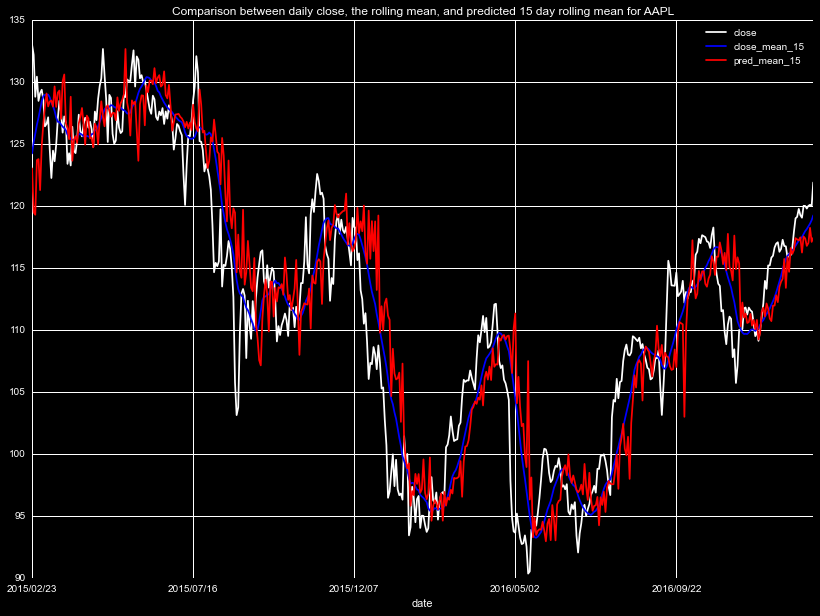

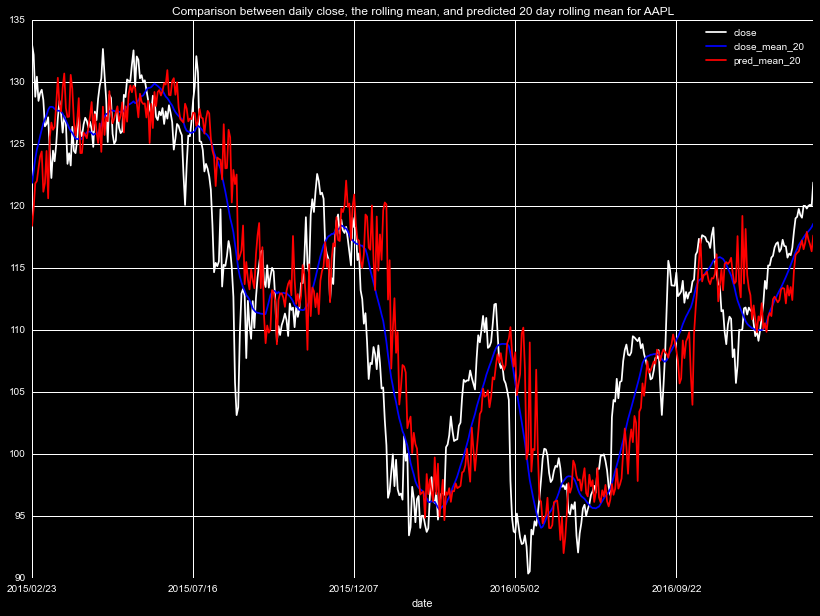

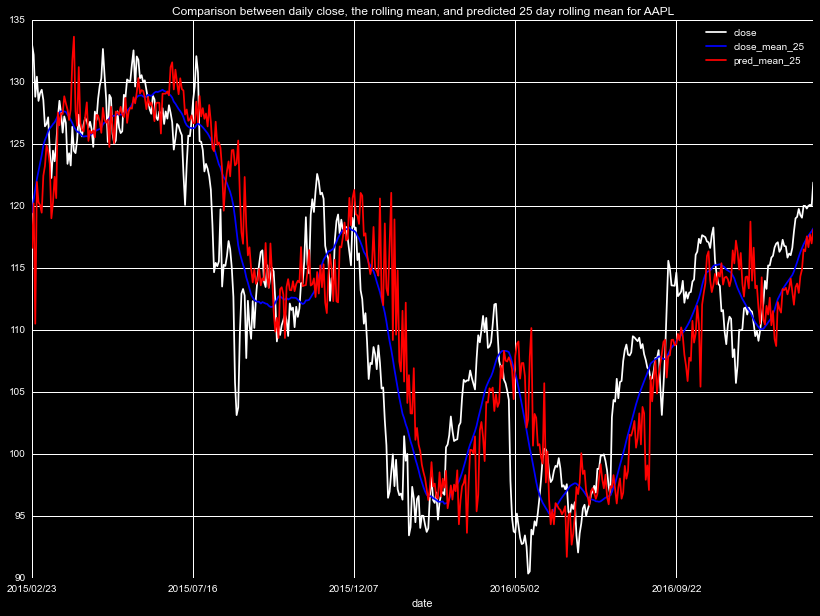

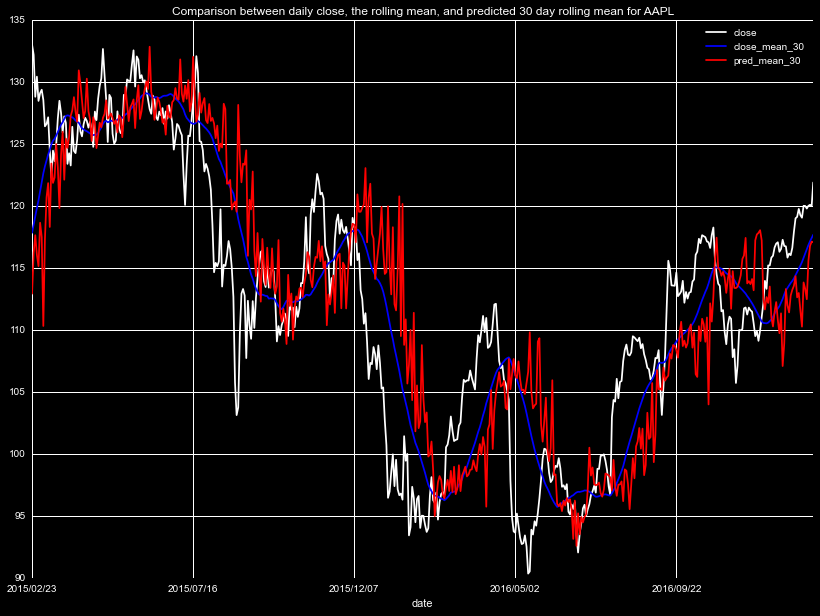

In [48]:
max_ind = close_df.shape[0]
low = int( 0.0*max_ind )
hi  = int( 0.2*max_ind )
for i in roll_nums:
    my_ax = plt.gca()
    close_df[hi:low:-1].plot( y = 'close'             , color='w', ax=my_ax )
    close_df[hi:low:-1].plot( y = 'close_mean_'+str(i), color='b', ax=my_ax )
    close_df[hi:low:-1].plot( y =  'pred_mean_'+str(i), color='r', ax=my_ax )
    plt.title( 'Comparison between daily close, the rolling mean, and predicted ' + str(i) + ' day rolling mean for AAPL' )
#    plt.ylim( 10, 30 )
    plt.show()

In [71]:
range( 10, 1 , -1)

[10, 9, 8, 7, 6, 5, 4, 3, 2]

In [150]:
def cubic_pandas_spline( inp_x, y, pred_x ):
    
    x      = np.array(inp_x)
    pred_x = np.array( pred_x )

    a = np.zeros( [y.shape[0], y.shape[1]+1] )
    b = np.zeros( [y.shape[0], y.shape[1]  ] )
    d = np.zeros( [y.shape[0], y.shape[1]  ] )
    
    h = np.ones( y.shape[1] )+1
    
    for i in range( 0, y.shape[1] ):
        a[:,i] = y[:,i]

    alpha = np.zeros( [y.shape[0], y.shape[1]] )
    alpha[:,1:] = 3./h[1:]*(a[:,2:]-a[:,1:-1]) - 3./h[:-1]*(a[:,1:-1]-a[:,:-2])

    c = np.zeros( [y.shape[0], y.shape[1]  ] )
    l = np.zeros( [y.shape[0], y.shape[1]  ] )
    m = np.zeros( [y.shape[0], y.shape[1]  ] )
    z = np.zeros( [y.shape[0], y.shape[1]  ] )

    l[:,0] = 1
    l[:,y.shape[1]-1] = 1
    
    for i in range( 1, y.shape[1]-1 ):
        l[:,i] = 2 * ( x[i+1] - x[i-1] ) - h[i-1] * m[:,i-1]
        m[:,i] = h[i] / l[:,i]
        z[:,i] = ( alpha[:,i]-h[i-1]*z[:,i-1] ) / l[:,i]
                
    for j in range( y.shape[1]-2, -1, -1 ):
        c[:,j] =  z[:,j]  -  m[:,j] *c[:,j+1]
        b[:,j] =((a[:,j+1]-  a[:,j])/h[  j  ] - 
                 (c[:,j+1]+2*c[:,j])*h[  j  ]/3. )
        d[:,j] = (c[:,j+1]-  c[:,j])/(h[ j  ]*3. )
                
    mid_index = int((y.shape[1])/2)
    
    ret_y = np.zeros( [y.shape[0],pred_x.shape[0]] )

    for i in range( 0, pred_x.shape[0] ):
        ret_y[:,i]= ( 
                 a[:,mid_index]*(pred_x[i]-inp_x[mid_index])**0 +
                 b[:,mid_index]*(pred_x[i]-inp_x[mid_index])**1 +
                 c[:,mid_index]*(pred_x[i]-inp_x[mid_index])**2 +
                 d[:,mid_index]*(pred_x[i]-inp_x[mid_index])**3 )
    
    return ret_y

In [204]:
# Predict using interpolation
def pred_from_mean( inp_close_df, roll_nums ):
    
    # Stores values predicted from mean
    my_df = inp_close_df['close'].to_frame()
    
    
    rolls = sorted( roll_nums )
    diff  = np.array( rolls[1:] )-np.array( rolls[:-1] )
    
    
    # First predict the first few days, indexing starts at 1
    roll_str = str( rolls[0] )
    mid      = str((rolls[0]+1)/2)
    
    my_df['pred_'+roll_str+'_day_1'         ] = my_df['close']
    
    # Odd
    if ( (rolls[0] % 2) == 1 ):
        my_df['pred_'+str( rolls[0] )+'_day_'+mid ] = inp_close_df['pred_mean_'+roll_str]

    my_df['pred_'+roll_str+'_day_'+roll_str ] =  2 * inp_close_df['pred_mean_'+roll_str ] - my_df['close']

    # Find values not covered
    predicted_list = [1,(rolls[0]+1)/2,rolls[0]]
    need_to_predict = [x for x in range(1,rolls[0]+1) if x not in predicted_list]

    
    # Find values not covered
    if ( len(need_to_predict) > 0 ):

        # Assemble data needing predicting
        x1 = my_df['pred_'+roll_str+'_day_1'        ]
        x5 = my_df['pred_'+roll_str+'_day_'+roll_str]
        str_pred_list = ['pred_'+roll_str+'_day_1','pred_'+roll_str+'_day_'+roll_str]
        
        if ( (rolls[0] % 2) == 1 ):
            x3 = my_df['pred_'+roll_str+'_day_'+mid]

            str_pred_list = ['pred_'+roll_str+'_day_1',
                             'pred_'+roll_str+'_day_'+mid,
                             'pred_'+roll_str+'_day_'+roll_str]
            
# Interpolation method could potentially be changed        

        # Predict using custom cubic spline, for pandas arrays
        preds = cubic_pandas_spline( predicted_list, my_df[str_pred_list].values, need_to_predict )
        
        # Save the interpolated arrays
        for i in range( 0, len(need_to_predict) ):
            my_df['pred_'+roll_str+'_day_'+str(need_to_predict[i])] = preds[:,i]

            
        
    # Need to take mean chunks, and calculate amount in later chunk
    # In later chunck, midpoint will be the mean value, interpolate
    #  from previous mean value centerpoint to find chunck x1,
    #  then use ( x5=2m-x1 ) to calcuate chunck x5, interpolate, repeat
        
    for i in range( 1, 4 ):#len(rolls) ):
        
        prev_str   = str(rolls[i-1])
        chunk_str  = str(rolls[i  ])
        
        prev_days  = rolls[i-1]
        tot_days   = rolls[i  ]
        chunk_days = tot_days - prev_days
        
        prev_mean  = inp_close_df['pred_mean_'+ prev_str]
        tot_mean   = inp_close_df['pred_mean_'+chunk_str]

        chunk_mean = ( tot_days*tot_mean - prev_days*prev_mean ) / ( chunk_days )
        
    
        # Odd, use midpoint
        # Will need these values for later iterations anyway
        prev_mid = int(mid)
        mid      = (chunk_days+1)/2
        mid_str  = str(mid)
        
        if ( (chunk_days % 2) == 1 ):


            my_df['pred_'+chunk_str+'_day_'+mid_str ] = chunk_mean
            
            
            # Get the first day from interpolation between two midpoints
            my_df['pred_'+chunk_str+'_day_1' ] = ( (      mid - 1 ) * chunk_mean  +
                                                   ( prev_mid     ) * my_df['pred_'+prev_str+'_day_'+str(prev_mid)] 
                                                 ) / (    mid - 1   + prev_mid ) 

            my_df['pred_'+chunk_str+'_day_'+str(chunk_days) ] =  2 * chunk_mean - my_df['pred_'+chunk_str+'_day_1' ]

            # Find values not covered
            predicted_list = [1,mid,chunk_days]
            need_to_predict = [x for x in range(1,chunk_days) if x not in predicted_list]

            # Find values not covered
            if ( len(need_to_predict) > 0 ):

                # Assemble data needing predicting
                x1 = my_df['pred_'+chunk_str+'_day_1'        ]
                x5 = my_df['pred_'+chunk_str+'_day_'+str(chunk_days)]
                str_pred_list = ['pred_'+chunk_str+'_day_1',
                                 'pred_'+chunk_str+'_day_'+mid_str,
                                 'pred_'+chunk_str+'_day_'+str(chunk_days)]

# Interpolation method could potentially be changed        

            

                # Predict using custom cubic spline, for pandas arrays
                preds = cubic_pandas_spline( predicted_list, my_df[str_pred_list].values, need_to_predict )

                
        # Even
        else:
            # Use mean difference, and difference from chunk to last day
            delta = inp_close_df['pred_mean_'+chunk_str] - my_df['pred_'+prev_str+'_day_'+str(diff[i-2])]
            my_df['pred_'+chunk_str+'_day_1'] = inp_close_df['pred_mean_'+chunk_str] - delta/2.
            my_df['pred_'+chunk_str+'_day_2'] = inp_close_df['pred_mean_'+chunk_str] + delta/2.
        
    print my_df.reindex_axis(sorted(my_df.columns), axis=1)

    
pred_from_mean( close_df, roll_nums[1:] )

               close  pred_10_day_1  pred_10_day_2  pred_15_day_1  \
date                                                                
2017/01/26  121.9400     120.094936     118.426136     115.060008   
2017/01/25  121.8800     120.068335     120.309920     114.606208   
2017/01/24  119.9700     119.276134     120.368733     114.172135   
2017/01/23  120.0800     118.806859     119.089596     117.451279   
2017/01/20  120.0000     117.347015     119.520649     115.214069   
2017/01/19  119.7800     118.717683     117.723776     115.478967   
2017/01/18  119.9900     116.966984     118.900048     116.473205   
2017/01/17  120.0000     117.777474     118.428275     116.833995   
2017/01/13  119.0400     109.994395     123.329091     113.573856   
2017/01/12  119.2500     112.221932     122.099387     116.103076   
2017/01/11  119.7500     115.982170     117.752647     117.266934   
2017/01/10  119.1100     115.553391     121.448530     115.098729   
2017/01/09  118.9900     116.62666